# Modèle de scoring


---

## Modélisation
Utilisation d'un GPU pour Catboost, LightGBM & XGBoost.


### Utilisation GPU

In [ ]:
#Appareils utilisés lors de l'exécution du notebook dans le cloud
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices ()

---

In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
error: RPC failed; curl 56 Recv failure: Connection was reset
error: 5718 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output


In [2]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu

Le chemin d'acc�s sp�cifi� est introuvable.


In [ ]:
!pip install catboost

### Utilisation CPU

In [ ]:
#Code CPU #!pip install catboost

In [ ]:
#Code CPU #!pip install lightgbm

### Implémentation

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time, pickle

from zipfile import ZipFile

#Prétraitement, suréchantillonnage, sélection de modèle, évaluation de modèle
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [6]:
#Téléchargement des fichiers depuis Google Drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [7]:
#Téléchargement des fichiers en local
repertoire_model = 'data-model/'
model_final = 'model-final/'
donnees = 'donnees/'

In [8]:
z = ZipFile(repertoire_model+"data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [9]:
TARGET = pd.read_csv(repertoire_model+'TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
La prédiction peut être simplifiée en deux résultats : l'approbation ou le rejet de crédit. Pour avoir une estimation initiale de ses performances, l'utilisation de la régression logistique pour la modélisation peut établir une référence.

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''Tracé d'une matrice de confusion sklearn utilisant une visualisation de carte thermique Seaborn + courbe ROC.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Négatif (TN)', 'Faux Positif (FP)', 'Faux Négatif (FN)', 'Vrai Positif (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positif')
    plt.legend()

    plt.show()

In [14]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6940
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: total: 5 s
Wall time: 1.96 s


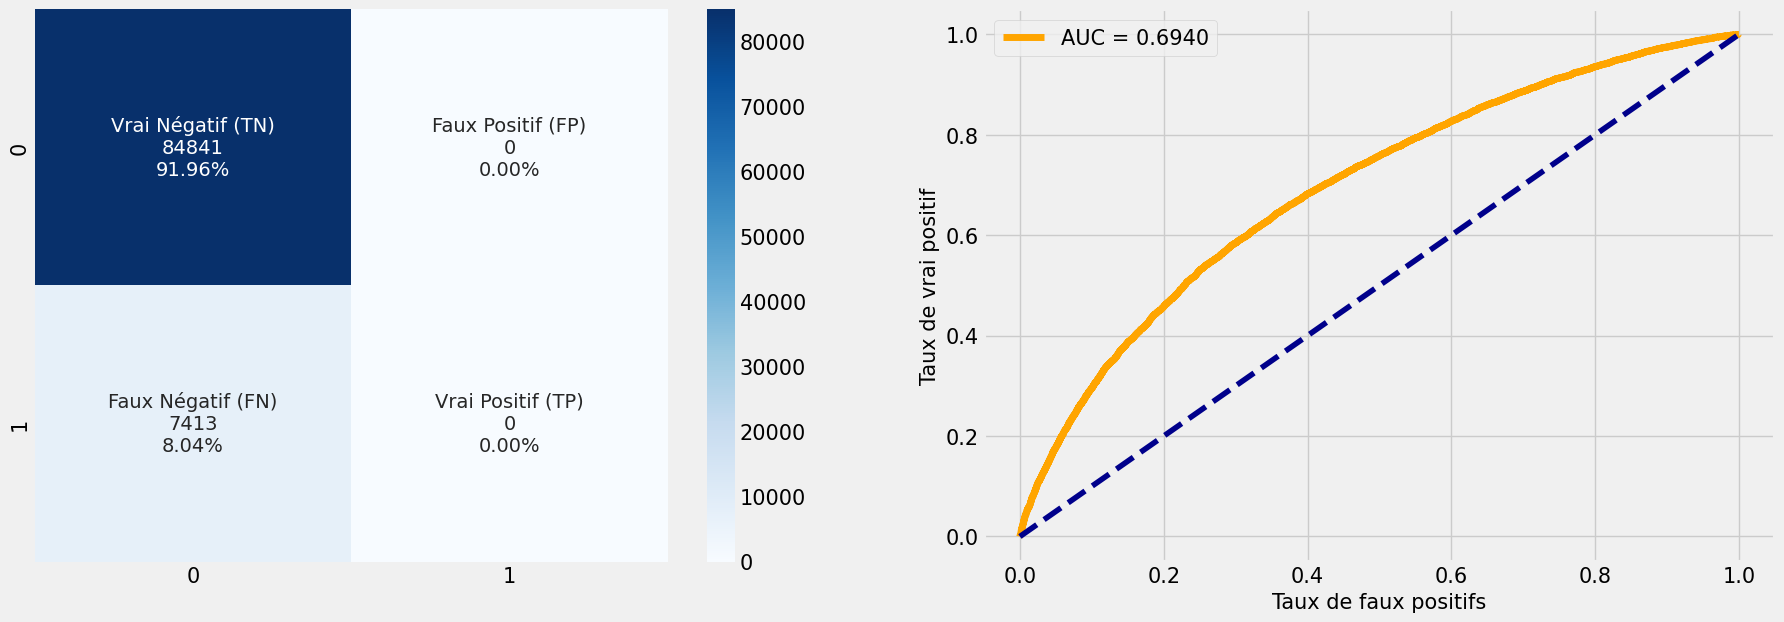

In [15]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1])

**Oversampling (Suréchantillonnage) SMOTE**

SMOTE avec Imbalance, les données utilisant le module imblearn



In [16]:
print("Label 1, Avant d'utiliser SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Avant d'utiliser SMOTE: {} ".format(sum(y_train==0)))

Label 1, Avant d'utiliser SMOTE: [17412] 
Label 0, Avant d'utiliser SMOTE: [197845] 


In [17]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: total: 7.45 s
Wall time: 2.34 s


In [18]:
print("Label 1, Après avoir utilisé SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, Après avoir utilisé SMOTE: {}".format(sum(y_train_res==0)))

Label 1, Après avoir utilisé SMOTE: 197845
Label 0, Après avoir utilisé SMOTE: 197845


In [19]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7197
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: total: 51.1 s
Wall time: 7.37 s


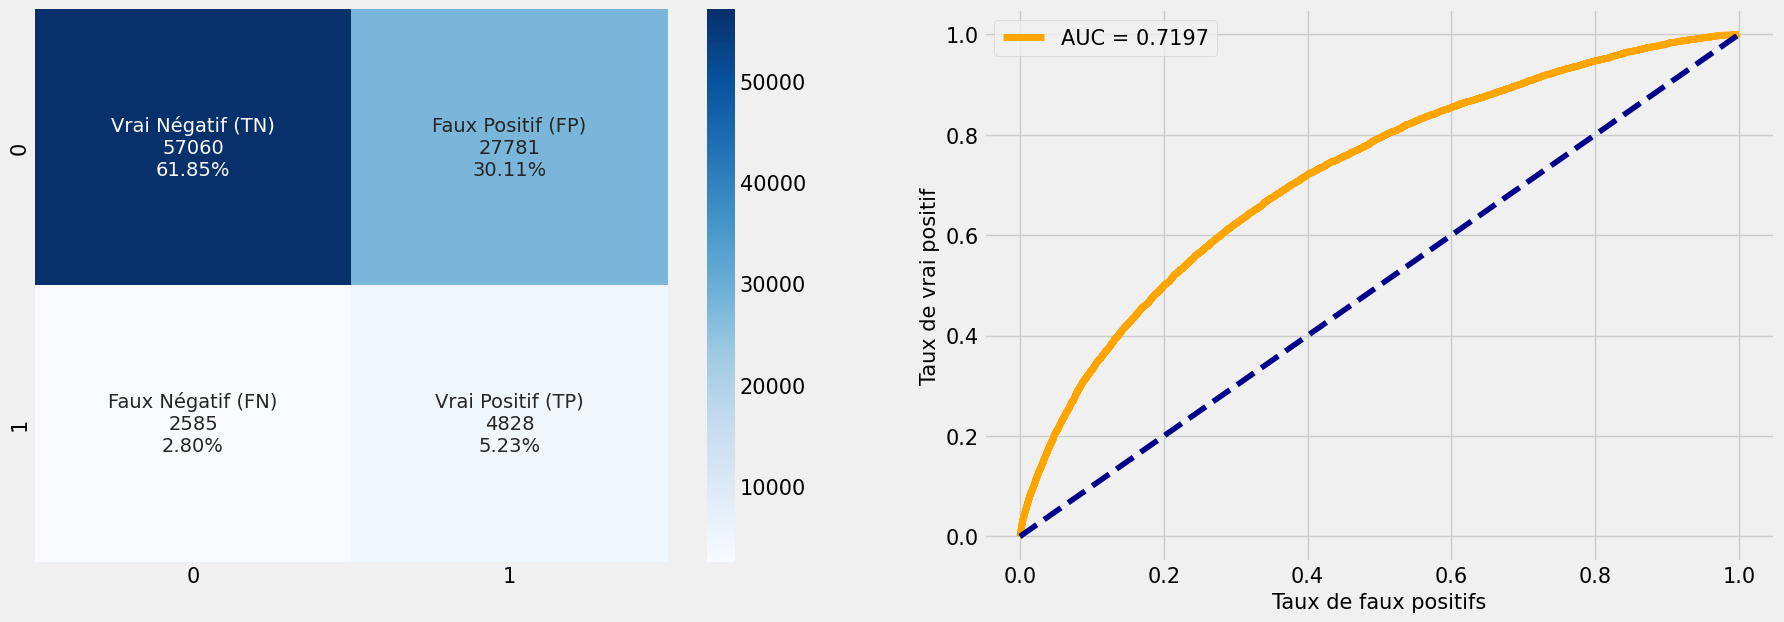

In [20]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1])

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### **Gradient Boosting**

In [21]:
#Modèles prédictifs GPU
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),  # GPU pour CatBoost
          LGBMClassifier(device='gpu'),  # GPU pour LightGBM
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]  # pour XGBoost


In [22]:
"""
Code CPU
#Modèles prédictifs CPU
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(task_type="CPU", logging_level='Silent'),  # CPU pour CatBoost
          LGBMClassifier(device='cpu'),  # CPU pour LightGBM
          XGBClassifier(tree_method='hist', predictor='cpu_predictor')]  # CPU pour XGBoost

"""


'\nCode CPU\n#Modèles prédictifs CPU\nfrom catboost import CatBoostClassifier\nfrom lightgbm import LGBMClassifier\nfrom xgboost import XGBClassifier\n\nmodels = [\n          CatBoostClassifier(task_type="CPU", logging_level=\'Silent\'),  # CPU pour CatBoost\n          LGBMClassifier(device=\'cpu\'),  # CPU pour LightGBM\n          XGBClassifier(tree_method=\'hist\', predictor=\'cpu_predictor\')]  # CPU pour XGBoost\n\n'

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [23]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }

    return output

In [24]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialisation des données de listes
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Temps (s)']
base_models.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27714
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 301
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (20.53 MB) transferred to GPU in 0.016037 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 1min 19s
Wall time: 1min 9s


In [25]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Temps (s)
0,CatBoostClassifier,0.775336,0.920144,0.556931,0.030352,0.057567,60.371525
1,LGBMClassifier,0.774624,0.919971,0.533937,0.031836,0.060089,3.944706
2,XGBClassifier,0.767821,0.919028,0.468716,0.057602,0.102595,4.7844


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [26]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialisation des données de listes
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Temps (s)']
models_res.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 67559
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 303
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 114 dense feature groups (43.77 MB) transferred to GPU in 0.028968 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 2min 6s
Wall time: 1min 40s


In [27]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Temps (s)
0,CatBoostClassifier,0.763326,0.919808,0.5179,0.029273,0.055414,84.48455
2,XGBClassifier,0.753406,0.91802,0.420551,0.053555,0.09501,9.397148
1,LGBMClassifier,0.752409,0.918865,0.398876,0.019156,0.036556,6.234929


LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### **Selection des caractéristiques (Feature selection) - Elimination des caractéristiques récursives**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [28]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'),
              step=5,
              cv=StratifiedKFold(5),
              scoring='roc_auc',
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Temps écoulé: {}'.format(time.time()-start))

Fitting estimator with 309 features.
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27714
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 301
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Fitting estimator with 304 features.
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27451
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 296


In [29]:
print("Nombre optimal de features : %d" % rfecv.n_features_)
print("Features sélectionnées: %s" % rfecv.support_[:20])
print("Classement des Feature : %s" % rfecv.ranking_[:20])

Nombre optimal de features : 119
Features sélectionnées: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Classement des Feature : [ 1  1 16  8  1  1  1  1  1  1  1  1  1  1 18 19  1 19 19 11]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [30]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

119
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_AMT_CREDIT', 'PREV_APPL_MEAN_AMT_APPLICATION', 'PREV_APPL_MEAN_AMT_ANNUITY', 'PREVIOUS_APPLICATION_COUNT', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 'PREV_BUR_MEAN_AM

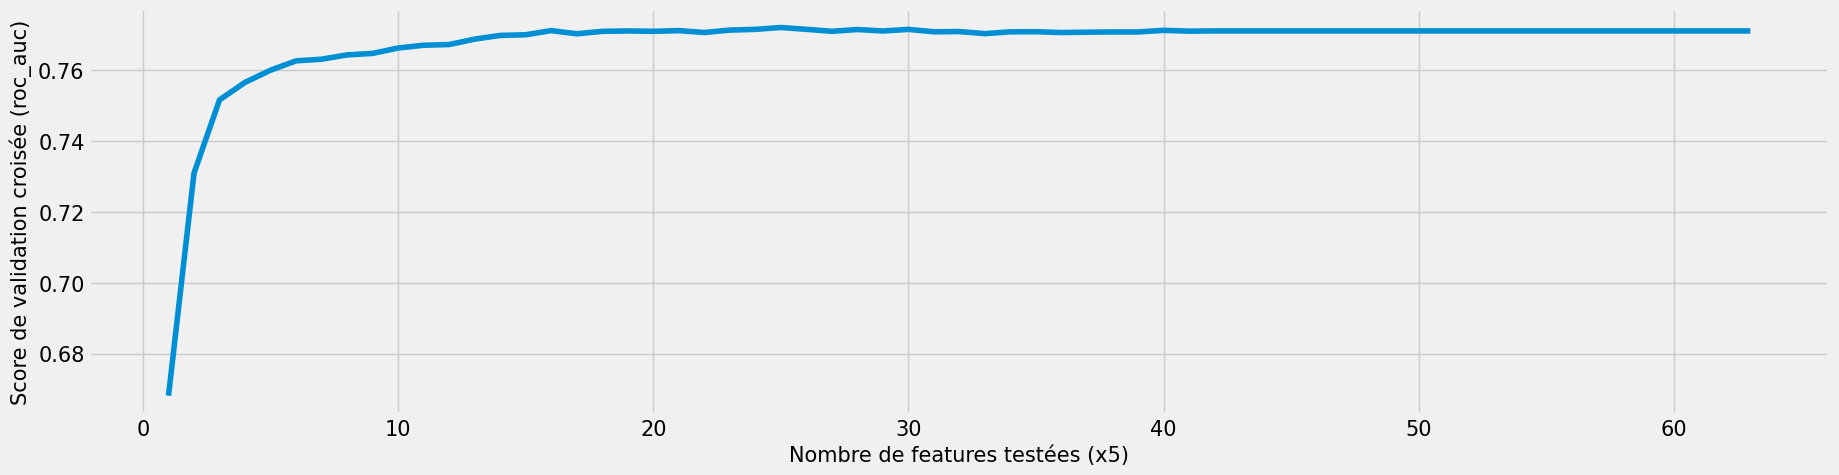

In [31]:

# Extraire les scores de cv_results_
scores = rfecv.cv_results_["mean_test_score"]

step = 5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('Nombre de features testées (x%d)' % step)
plt.ylabel('Score de validation croisée (roc_auc)')
plt.show()


RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [32]:
#X_data est très important pour implémenter la courbe de l'importance des fonctionnalités...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 119)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [33]:
#Opération de fusion avec la cible (TARGET) avant de sauvegarder cet échantillon réduit
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [34]:
X_data.shape

(307511, 120)

In [35]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv(donnees+'X_data.zip', index=True, compression=compression_opts)

CPU times: total: 21.2 s
Wall time: 59 s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [36]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv(donnees+'X_sample.zip', index=True, compression=compression_opts)

CPU times: total: 2.42 s
Wall time: 5.85 s


In [37]:
%%time
X_data.sample(10000).to_csv(donnees+'X_sample.csv', index=True)

CPU times: total: 656 ms
Wall time: 1.23 s


In [38]:
#Transformation des données avec rfecv
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [39]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Méthodes d'Ensemble GPU
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }

    return output

In [40]:
"""
Code CPU
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Méthodes d'Ensemble CPU
          CatBoostClassifier(task_type="CPU", logging_level='Silent'),
          LGBMClassifier(device='cpu'),
          XGBClassifier(tree_method='hist', predictor='cpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }

    return output

"""

'\nCode CPU\ndef train_models(model, X_train_selected, X_test_selected, y_train, y_test):\n    models = [\n          #Méthodes d\'Ensemble CPU\n          CatBoostClassifier(task_type="CPU", logging_level=\'Silent\'),\n          LGBMClassifier(device=\'cpu\'),\n          XGBClassifier(tree_method=\'hist\', predictor=\'cpu_predictor\')\n          ]\n\n    model.fit(X_train_selected, y_train)\n    output = {\n      \'AUC\': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),\n      \'Accuracy\': accuracy_score(y_test, model.predict(X_test_selected)),\n      \'Precision\': precision_score(y_test, model.predict(X_test_selected)),\n      \'Recall\': recall_score(y_test, model.predict(X_test_selected)),\n      \'F1\': f1_score(y_test, model.predict(X_test_selected))\n      }\n\n    return output\n\n'

In [41]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialisation des données de listes
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Temps (s)']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 21137
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 74 dense feature groups (15.60 MB) transferred to GPU in 0.015002 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 46.3 s
Wall time: 19.1 s


In [42]:
#Performances des modèles avec sélection de fonctionnalités (features)
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Temps (s)
0,CatBoostClassifier,0.77569,0.920209,0.562802,0.031431,0.059537,12.544317
1,LGBMClassifier,0.773938,0.920166,0.553571,0.033455,0.063096,3.396568
2,XGBClassifier,0.767424,0.918854,0.461376,0.058816,0.104331,3.206271


In [43]:
###Rappel avant… la sélection des fonctionnalités (features)
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Temps (s)
0,CatBoostClassifier,0.775336,0.920144,0.556931,0.030352,0.057567,60.371525
1,LGBMClassifier,0.774624,0.919971,0.533937,0.031836,0.060089,3.944706
2,XGBClassifier,0.767821,0.919028,0.468716,0.057602,0.102595,4.7844


**LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative.

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive.

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall :
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



In [44]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''Fonction de scoring'''
    tp, tn, fp, fn = predictions_success

    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))

    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [45]:
def custom_score(y_true, y_pred, beta=3) :
    '''fonction de pénalisation de fp et fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [46]:
def cost_false(model, y_true, X_true):
    '''Conction de coût analyse les erreurs de prédiction Faux Positif et Faux Négatif'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)

    print("Faux Positif: {0:.2%}".format(FP))
    print("Faux Négatif: {0:.2%}".format(FN))
    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [47]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [48]:
#Espace de paramètres
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [49]:
def objective(params, eval_metric='custom_score'):
    #fonction objectif à minimiser.
    #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }


    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [50]:
"""
Code CPU
def objective(params, eval_metric='custom_score'):
    #fonction objectif à minimiser.
    #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'cpu'
        }


    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

"""

"\nCode CPU\ndef objective(params, eval_metric='custom_score'):\n    #fonction objectif à minimiser.\n    #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.\n\n    params = {\n        'n_estimators': int(params['n_estimators']),\n        'learning_rate': params['learning_rate'],\n        'max_depth': int(params['max_depth']),\n        'subsample': params['subsample'],\n        'colsample_bytree': params['colsample_bytree'],\n        'reg_lambda': params['reg_lambda'],\n        'device':'cpu'\n        }\n\n\n    model= LGBMClassifier(**params)\n    cv = StratifiedKFold(5)\n    if eval_metric == 'roc_auc':\n        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()\n\n    elif eval_metric == 'custom_score':\n        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)\n        score = custom_score(y_train, y_pred)\n\n    loss = 1 - score\n    return {'loss': loss, 'params': params, 'status': STATU

In [51]:
# Définir la graine de génération de nombres aléatoires
np.random.seed(1)

# Lancer l'optimisation des hyperparamètres
best = fmin(fn=objective, space=space, max_evals=30, algo=tpe.suggest)

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {best}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276
[LightGBM] [Info] This is the GPU trainer!!           
[LightGBM] [Info] Total Bins 21106                    
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built        
[LightGBM] [Info] Size of histogram bin entry: 8      
[LightGBM] [Info] 74 dense feature groups (12.48 MB) transferred to GPU in 0.012192 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367
[

In [52]:
%%time
lgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open(model_final+"LGBMClassifier.pkl", "wb"))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 21137
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 74 dense feature groups (15.60 MB) transferred to GPU in 0.014663 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2

In [53]:
"""
Code CPU
%%time
lgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open(model_final+"LGBMClassifier.pkl", "wb"))

"""

'\nCode CPU\n%%time\nlgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres\n    n_estimators=int(best[\'n_estimators\']),\n    colsample_bytree= best[\'colsample_bytree\'],\n    learning_rate= best[\'learning_rate\'],\n    max_depth= int(best[\'max_depth\']),\n    subsample= best[\'subsample\'],\n    reg_lambda= best[\'reg_lambda\'],\n    device=\'cpu\')\n\nlgbm.fit(X_train_selected, y_train)\npickle.dump(lgbm, open(model_final+"LGBMClassifier.pkl", "wb"))\n\n'

In [54]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.779297


In [55]:
def cf_matrix_roc_auc_importance(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''Cette fonction fera une jolie courbe d'une matrice de confusion
    sklearn utilisant une visualisation de carte thermique Seaborn + courbe ROC.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Négatif', 'Faux Positif', 'Faux Négatif', 'Vrai Positif']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positif')
    plt.legend()

    plt.subplot(212)
    indices = np.argsort(model.feature_importances_)[::-1]
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #Après sélection RFECV > X_data sera créé

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Importance des Features')
    plt.xticks(rotation=90)

    plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


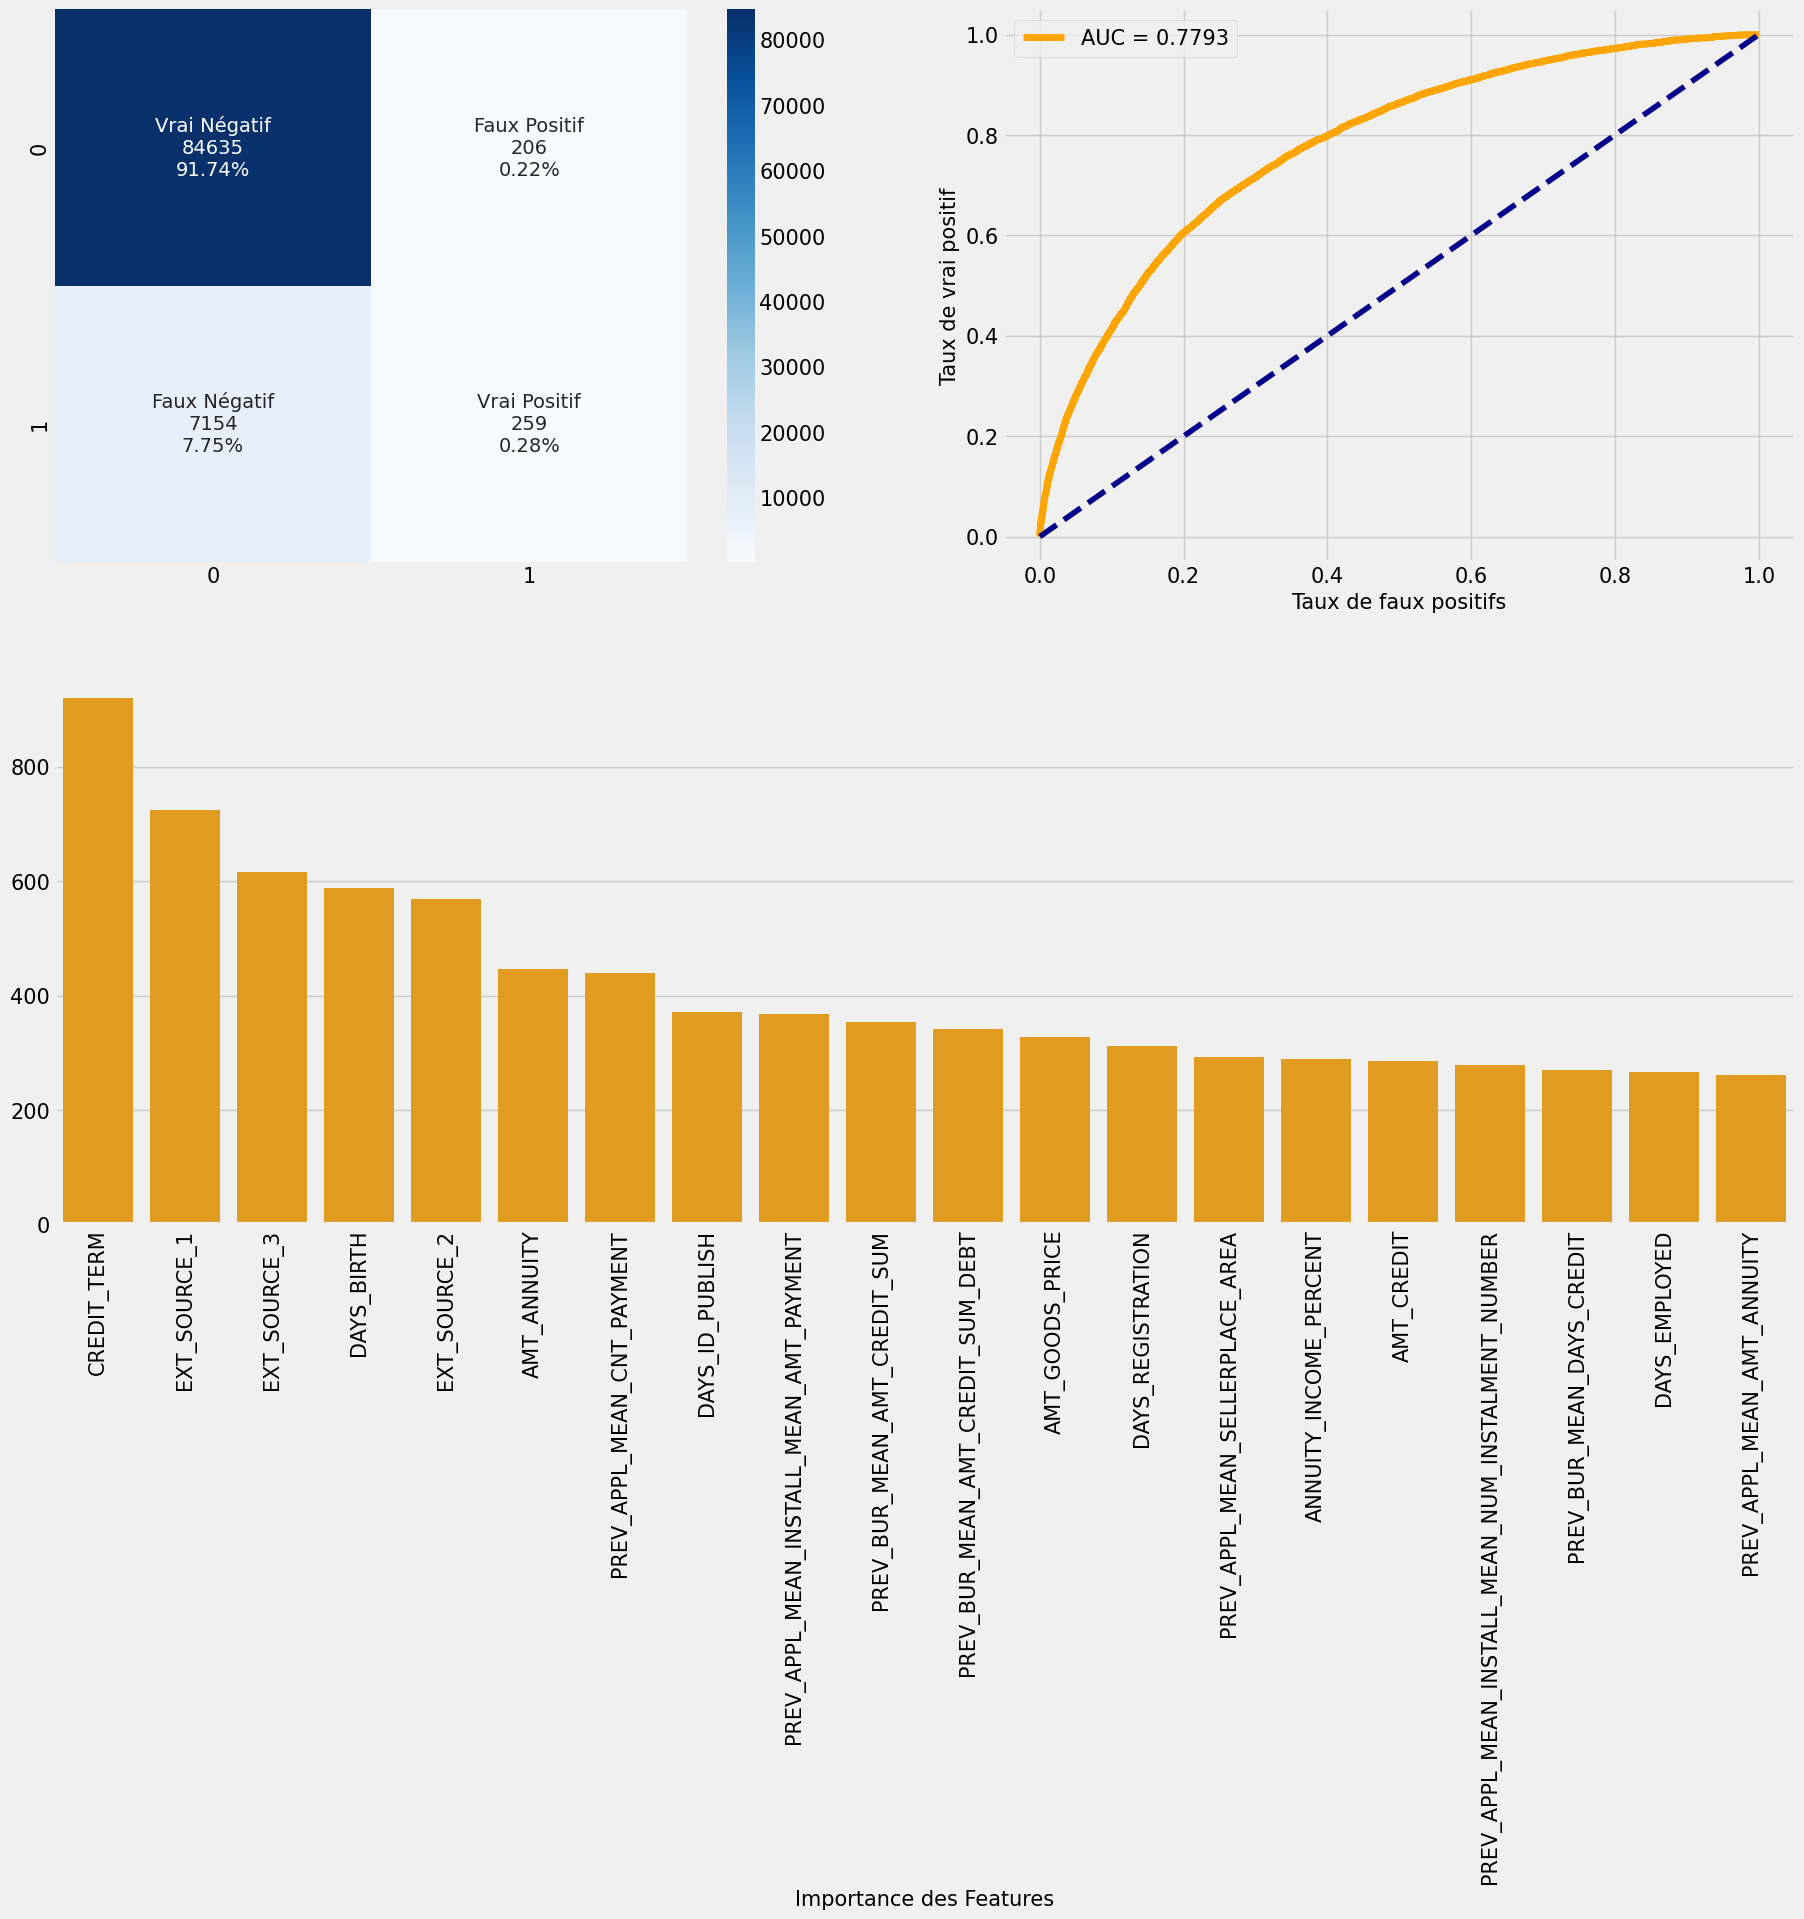

In [56]:
cf_matrix_roc_auc_importance(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [57]:
#FP et FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Faux Positif: 0.22%
Faux Négatif: 7.75%


(0.0022329655082706443, 0.07754677303965139)

In [58]:
#Liste des features importantes
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 919]
['EXT_SOURCE_1', 725]
['EXT_SOURCE_3', 615]
['DAYS_BIRTH', 587]
['EXT_SOURCE_2', 568]
['AMT_ANNUITY', 446]
['PREV_APPL_MEAN_CNT_PAYMENT', 440]
['DAYS_ID_PUBLISH', 371]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 368]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 354]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 341]
['AMT_GOODS_PRICE', 327]
['DAYS_REGISTRATION', 312]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 293]
['ANNUITY_INCOME_PERCENT', 289]
['AMT_CREDIT', 286]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 279]
['PREV_BUR_MEAN_DAYS_CREDIT', 270]
['DAYS_EMPLOYED', 267]
['PREV_APPL_MEAN_AMT_ANNUITY', 262]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 258]
['DAYS_LAST_PHONE_CHANGE', 257]
['DAYS_EMPLOYED_PERCENT', 250]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 228]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 214]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 213]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 210]
['AMT_INCOME_TOTAL', 206]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 204]
['REGION_POPUL

In [59]:
def objective(params, eval_metric='roc_auc'):
  #fonction objectif à minimiser.
  #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'}


    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [60]:
"""
Code CPU
def objective(params, eval_metric='roc_auc'):
  #fonction objectif à minimiser.
  #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'cpu'}


    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

"""

"\nCode CPU\ndef objective(params, eval_metric='roc_auc'):\n  #fonction objectif à minimiser.\n  #Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.\n\n    params = {\n        'n_estimators': int(params['n_estimators']),\n        'learning_rate': params['learning_rate'],\n        'max_depth': int(params['max_depth']),\n        'subsample': params['subsample'],\n        'colsample_bytree': params['colsample_bytree'],\n        'reg_lambda': params['reg_lambda'],\n        'device':'cpu'}\n\n\n    model= LGBMClassifier(**params)\n    cv = StratifiedKFold(5)\n    if eval_metric == 'roc_auc':\n        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()\n\n    elif eval_metric == 'custom_score':\n        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)\n        score = custom_score(y_train, y_pred)\n\n    loss = 1 - score\n    return {'loss': loss, 'params': params, 'status': STATUS_OK}\n\n"

In [61]:
# Définir la graine de génération de nombres aléatoires
np.random.seed(1)

# Lancer l'optimisation des hyperparamètres
best = fmin(fn=objective, space=space, max_evals=30, algo=tpe.suggest)

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {best}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276
[LightGBM] [Info] This is the GPU trainer!!           
[LightGBM] [Info] Total Bins 21106                    
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built        
[LightGBM] [Info] Size of histogram bin entry: 8      
[LightGBM] [Info] 74 dense feature groups (12.48 MB) transferred to GPU in 0.012538 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367
[

In [62]:
%%time
lgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open(model_final"LGBMClassifier.pkl", "wb"))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 21137
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 74 dense feature groups (15.60 MB) transferred to GPU in 0.013300 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2

LGBMClassifier(colsample_bytree=0.6168436697213189, device='gpu',
               learning_rate=0.029973356569431543, max_depth=7,
               n_estimators=600, reg_lambda=2.144267867296067,
               subsample=0.664917310907367)

In [63]:
"""
Code CPU
%%time
lgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='cpu')

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open(model_final"LGBMClassifier.pkl", "wb"))

"""

'\nCode CPU\n%%time\nlgbm = LGBMClassifier( #Ajuste un nouveau modèle basé sur les meilleurs paramètres\n    n_estimators=int(best[\'n_estimators\']),\n    colsample_bytree= best[\'colsample_bytree\'],\n    learning_rate= best[\'learning_rate\'],\n    max_depth= int(best[\'max_depth\']),\n    subsample= best[\'subsample\'],\n    reg_lambda= best[\'reg_lambda\'],\n    device=\'cpu\')\n\nlgbm.fit(X_train_selected, y_train)\n#pickle.dump(lgbm, open(model_final"LGBMClassifier.pkl", "wb"))\n\n'

In [64]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.780065


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


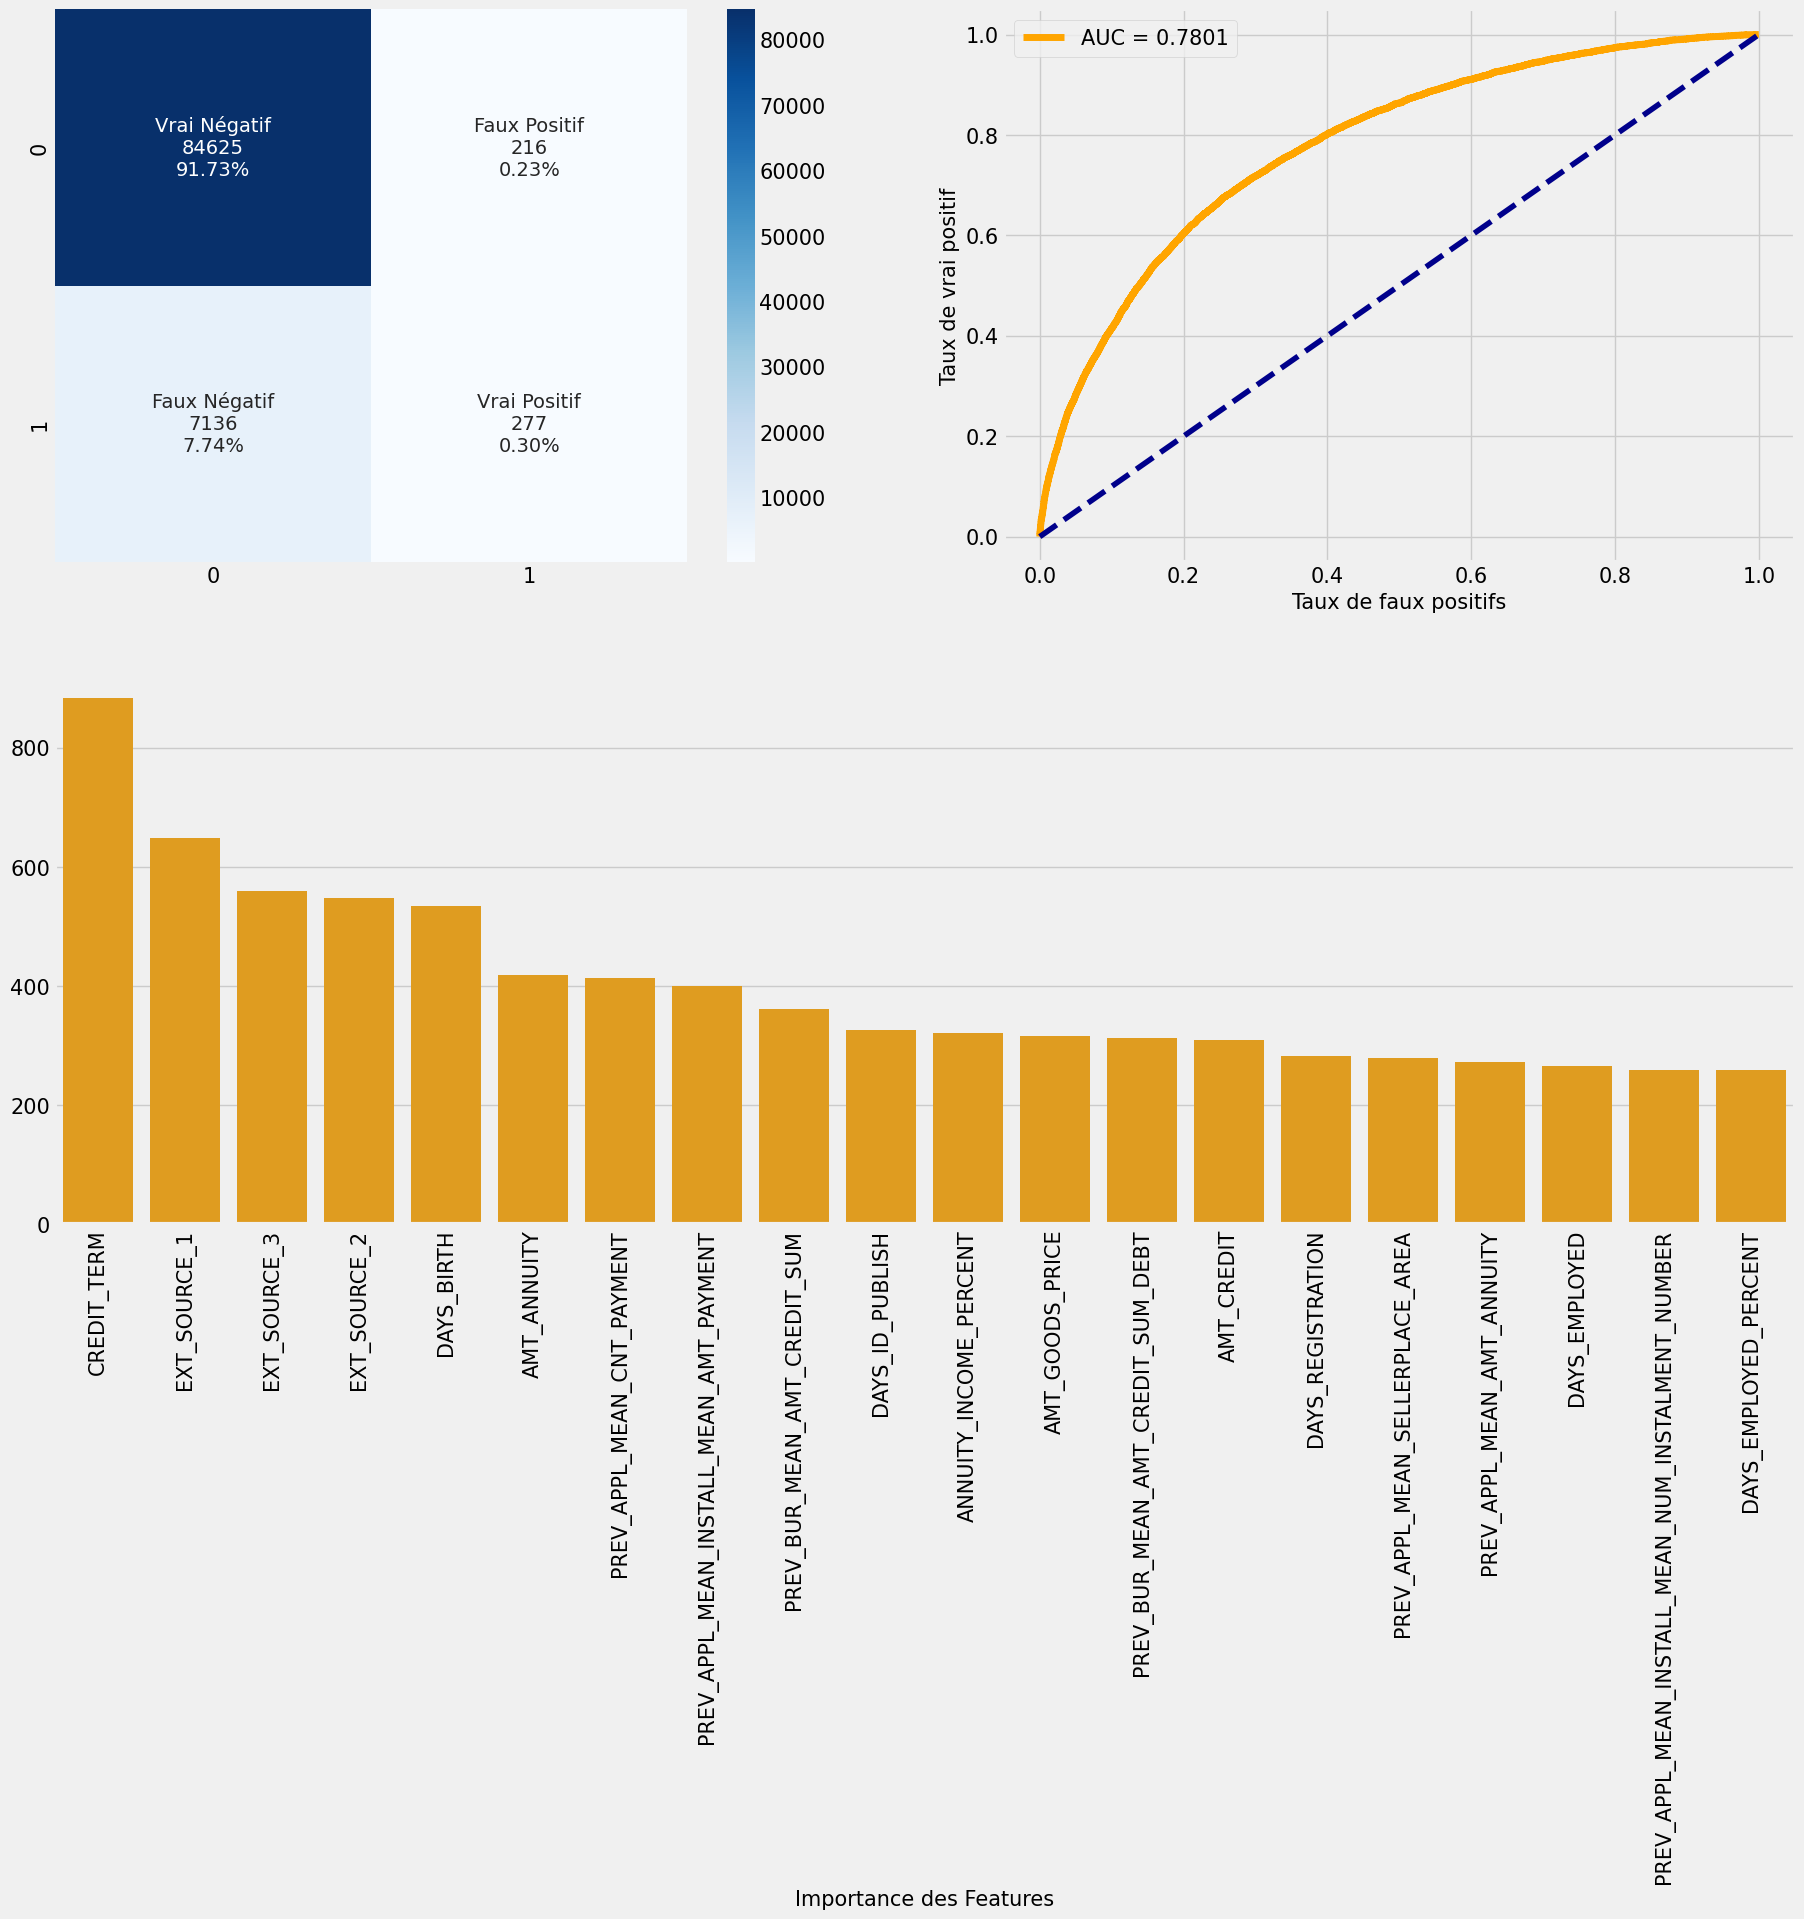

In [65]:
cf_matrix_roc_auc_importance(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [66]:
#FP et FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Faux Positif: 0.23%
Faux Négatif: 7.74%


(0.0023413618921672773, 0.07735165954863746)

In [67]:
#Liste des features importantes
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 883]
['EXT_SOURCE_1', 649]
['EXT_SOURCE_3', 559]
['EXT_SOURCE_2', 548]
['DAYS_BIRTH', 534]
['AMT_ANNUITY', 419]
['PREV_APPL_MEAN_CNT_PAYMENT', 414]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 400]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 362]
['DAYS_ID_PUBLISH', 326]
['ANNUITY_INCOME_PERCENT', 321]
['AMT_GOODS_PRICE', 317]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 313]
['AMT_CREDIT', 309]
['DAYS_REGISTRATION', 283]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 279]
['PREV_APPL_MEAN_AMT_ANNUITY', 272]
['DAYS_EMPLOYED', 266]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 260]
['DAYS_EMPLOYED_PERCENT', 259]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 253]
['PREV_BUR_MEAN_DAYS_CREDIT', 251]
['DAYS_LAST_PHONE_CHANGE', 245]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 245]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 223]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 220]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 219]
['CREDIT_INCOME_PERCENT', 209]
['PREV_APPL_MEAN_DAYS_DECISION', 203]
['

**Conclusion**\
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.